In [2]:
import numpy as np
from PIL import Image

import os

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dset


from deepdream import util as ddutil
from deepdream import resnet as ddresnet
from deepdream.deepdream import dream

import matplotlib.pyplot as plt
%matplotlib inline

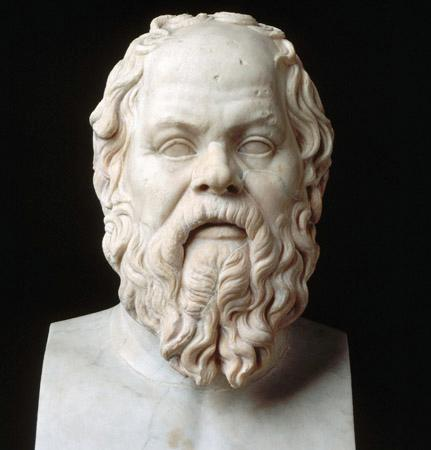

In [116]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
base_dream_path = './deepdream/data/base/'

# transform = transforms.Compose([transforms.Scale((224,224)),transforms.ToTensor()])

dream_set = dset.ImageFolder(base_dream_path,transform=transform)
# dset = datasets.ImageFolder(os.path.join(), transforms)
dset_loader = torch.utils.data.DataLoader(dream_set, batch_size=1)
inputs, classes = next(iter(dset_loader))
input_np = inputs.numpy()

ddutil.showtensor(input_np)

# base_image = Image.fromarray(np.uint8(input_np * 255)).convert('RGBA')
# plt.imshow(base_image)

In [117]:
# load the model
model = ddresnet.resnet50(pretrained=True)
model.cuda()
for param in model.parameters():
    param.require_grads = False

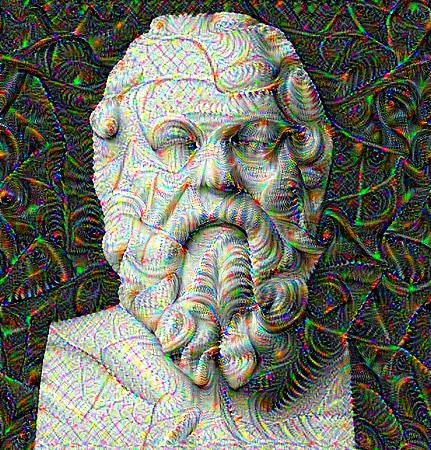

In [122]:
# deep dream
dream(model, input_np, 
          octave_n=3, 
          num_iterations=20, 
          lr=.1,
          max_jitter=50,
          show_every=10,
          end_layer=2)

In [ ]:
# To do:
# Update with model with more layers
# figure out how to activate specific neurons
# you need to draw to screen until cancel while being
# if you can do the above can you adjust which layer you're using at run

# Control the dream

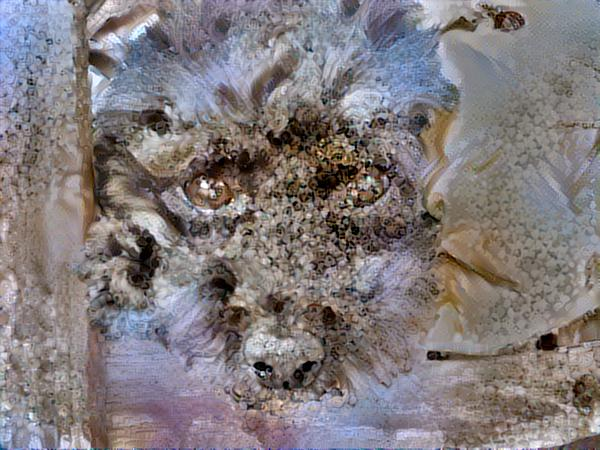

In [123]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
base_dream_path = './deepdream/data/target/'

# transform = transforms.Compose([transforms.Scale((224,224)),transforms.ToTensor()])

dream_set = dset.ImageFolder(base_dream_path,transform=transform)
# dset = datasets.ImageFolder(os.path.join(), transforms)
dset_loader = torch.utils.data.DataLoader(dream_set, batch_size=1)
inputs_guide, classes_guide = next(iter(dset_loader))
inputs_guide_np = inputs_guide.numpy()

ddutil.showtensor(inputs_guide_np)

# base_image = Image.fromarray(np.uint8(input_np * 255)).convert('RGBA')
# plt.imshow(base_image)

In [125]:
model = ddresnet.resnet50(pretrained=True)
model.cuda()
for param in model.parameters():
    param.require_grads = False

X_Variable = Variable(inputs_guide.cuda())
guide_features = model.forward(X_Variable, n_layer=3)

In [126]:
def objective_guide(dst, guide_features):
#     print(1)
    x = dst.data[0].cpu().numpy().copy()
#     print(type(dst), dst.size(), dst)
#     print(type(guide_features))
    y = guide_features.data[0].cpu().numpy()
#     print(dst.size())
    ch, w, h = x.shape
    x = x.reshape(ch,-1)      # (c，w*h)
    y = y.reshape(ch,-1)      # (c, w*h)
    A = x.T.dot(y) # compute the matrix of dot-products with guide features
    result = y[:,A.argmax(1)] # select ones that match best
    result = torch.Tensor(np.array([result.reshape(ch, w, h)], dtype=np.float)).cuda()
#     print(type(result), result.size(), result)
    return result

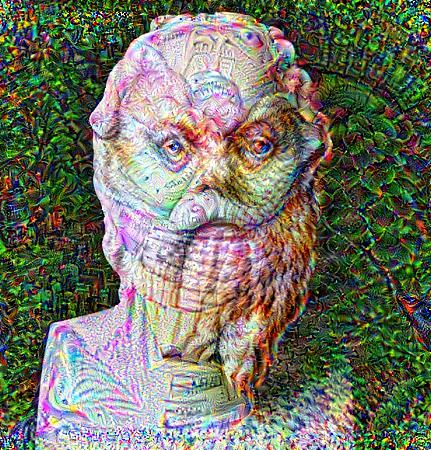

In [159]:
dream(model, input_np, 
          octave_n=5, 
          num_iterations=12, 
          lr=.12,
          max_jitter=20,
          show_every=10,
          end_layer=3,
          objective=objective_guide,
          guide_features=guide_features)